# Objective

* To identify which users most likely NOT enroll in paid products, so that additional offers can be given to them.


Data source : https://www.kaggle.com/abhishek2602/appdata10?select=appdata10.csv

# Import & Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil import parser


from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import itertools

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [2]:
def make_confusion_matrix(y_true,y_pred,classes=None, figsize=(10,10),text_size=15):
        """
        # Note: The following confusion matrix code is a remix of Scikit-Learn's 
        # plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
        # and Made with ML's introductory notebook - https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_TF_Multilayer_Perceptrons.ipynb
        """
    
        # Create the confusion matrix
        cm = confusion_matrix(y_true, tf.round(y_pred))
        cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
        n_classes = cm.shape[0]

        # Let's prettify it
        fig, ax = plt.subplots(figsize=figsize)
        # Create a matrix plot
        cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
        fig.colorbar(cax)
        #set labels to classes

        if classes:
            labels = classes
        else:
            labels = np.arange(cm.shape[0])

        # Label the axes
        ax.set(title="Confusion Matrix",
                xlabel="Predicted label",
                ylabel="True label",
                xticks=np.arange(n_classes),
                yticks=np.arange(n_classes),
                xticklabels=labels,
                yticklabels=labels)

        # Set x-axis labels to bottom
        ax.xaxis.set_label_position("bottom")
        ax.xaxis.tick_bottom()

        # Adjust label size
        ax.xaxis.label.set_size(text_size)
        ax.yaxis.label.set_size(text_size)
        ax.title.set_size(text_size)

        # Set threshold for different colors
        threshold = (cm.max() + cm.min()) / 2.

        # Plot the text on each cell
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)
    


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Visualisation & Processing

In [3]:
df=pd.read_csv(r"C:\Users\noname797\Documents\ML_projects\Case_study\Datasets\appdata10.csv")


In [4]:
df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [5]:
df.describe()

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df["hour"] = df.hour.str.slice(1, 3).astype(int)

s = pd.Series(["koala", "fox", "chameleon"])

s
0        koala
1          fox
2    chameleon
dtype: object

s.str.slice(start=1)
0        oala
1          ox
2    hameleon
dtype: object

s.str.slice(start=-1)
0           a
1           x
2           n
dtype: object

s.str.slice(stop=2)
0    ko
1    fo
2    ch
dtype: object

In [7]:
df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [8]:
df_copy=df.copy()

In [9]:
df_copy=df_copy.iloc[:,1:]
df_copy.head()

,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,2012-12-27 02:14:51.273,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,2012-12-02 01:16:00.905,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,2013-03-19 19:19:09.157,1,19,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,2013-07-05 16:08:46.354,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,2013-02-26 18:50:48.661,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


array([[<AxesSubplot:title={'center':'dayofweek'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'numscreens'}>,
        <AxesSubplot:title={'center':'minigame'}>,
        <AxesSubplot:title={'center':'used_premium_feature'}>],
       [<AxesSubplot:title={'center':'enrolled'}>,
        <AxesSubplot:title={'center':'liked'}>, <AxesSubplot:>]],
      dtype=object)

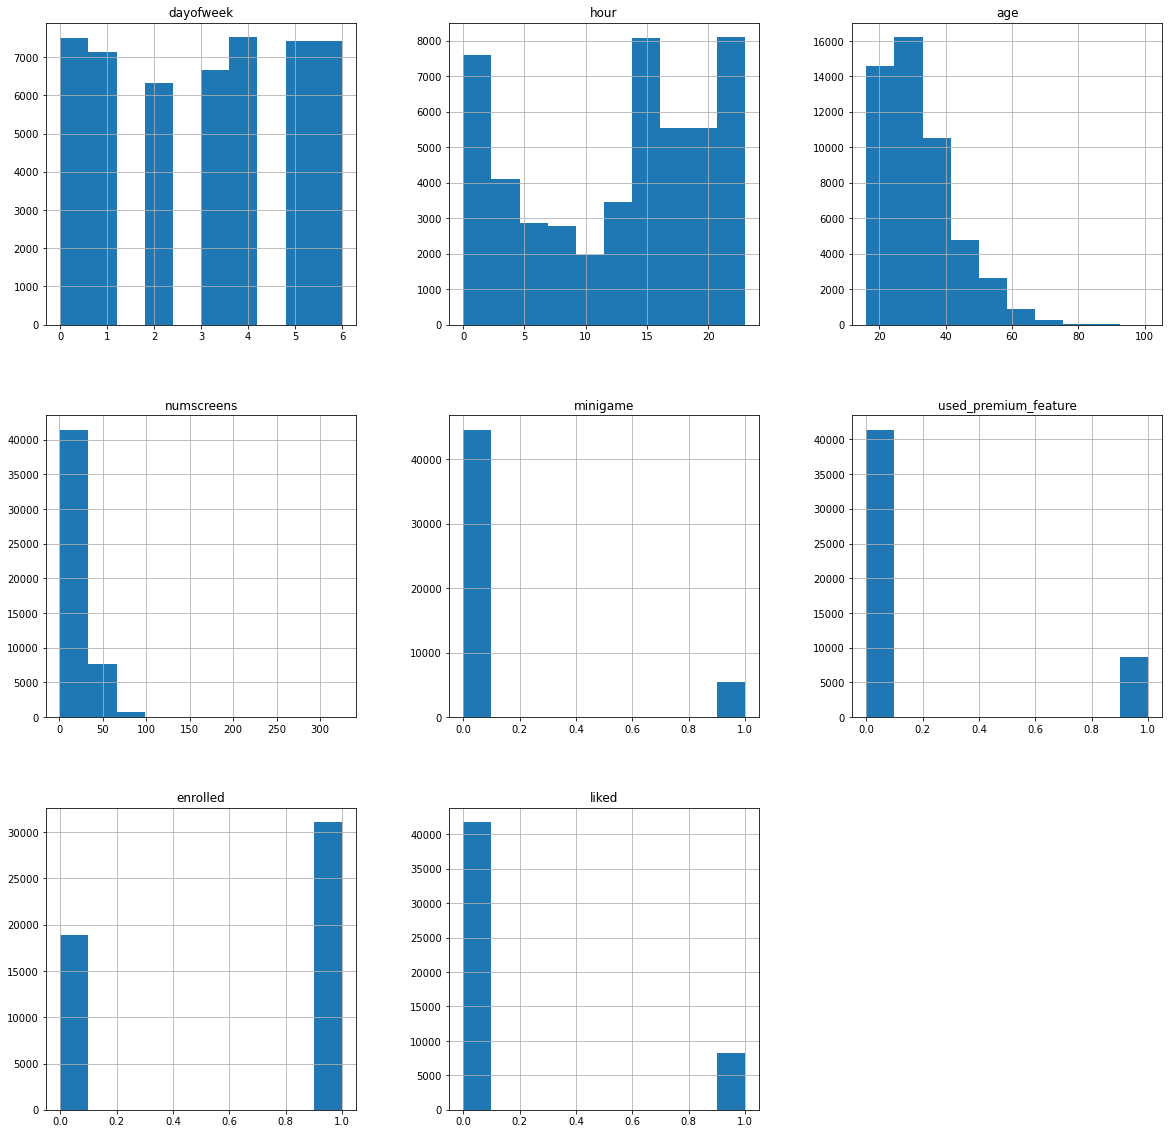

In [10]:
df_copy.hist(figsize=(20,20))

In [11]:
# #OR 
# dataset2 = df.copy().drop(columns = ['user', 'screen_list', 'enrolled_date',
#                                            'first_open', 'enrolled'])
# plt.suptitle('Histograms of Numerical Columns', fontsize=20)
# for i in range(1, dataset2.shape[1] + 1):
#     plt.subplot(3, 3, i)
#     f = plt.gca()
#     f.axes.get_yaxis().set_visible(False)
#     f.set_title(dataset2.columns.values[i - 1])

#     vals = np.size(dataset2.iloc[:, i - 1].unique())
    
#     plt.hist(dataset2.iloc[:, i - 1], bins=vals, color='#3F5D7D')
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig('app_data_hist.jpg')

In [12]:
df_copy=df.copy().drop(columns = ['user', 'screen_list', 'enrolled_date',
                                           'first_open', 'enrolled'])
df_copy.head()                     

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


<AxesSubplot:title={'center':'Correlation with Reposnse variable'}>

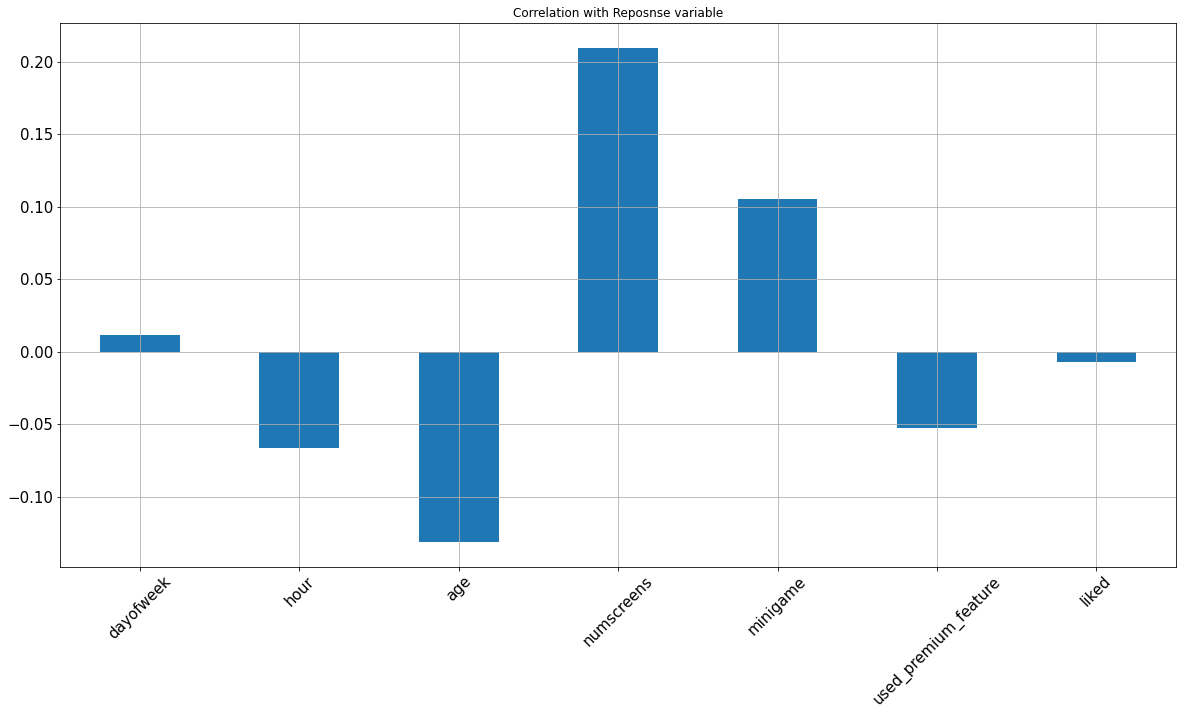

In [13]:
df_copy.corrwith(df.enrolled).plot.bar(figsize=(20,10),
                  title = 'Correlation with Reposnse variable',
                  fontsize = 15, rot = 45,
                  grid = True)


<ipython-input-14-aaf47b4c52ac>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

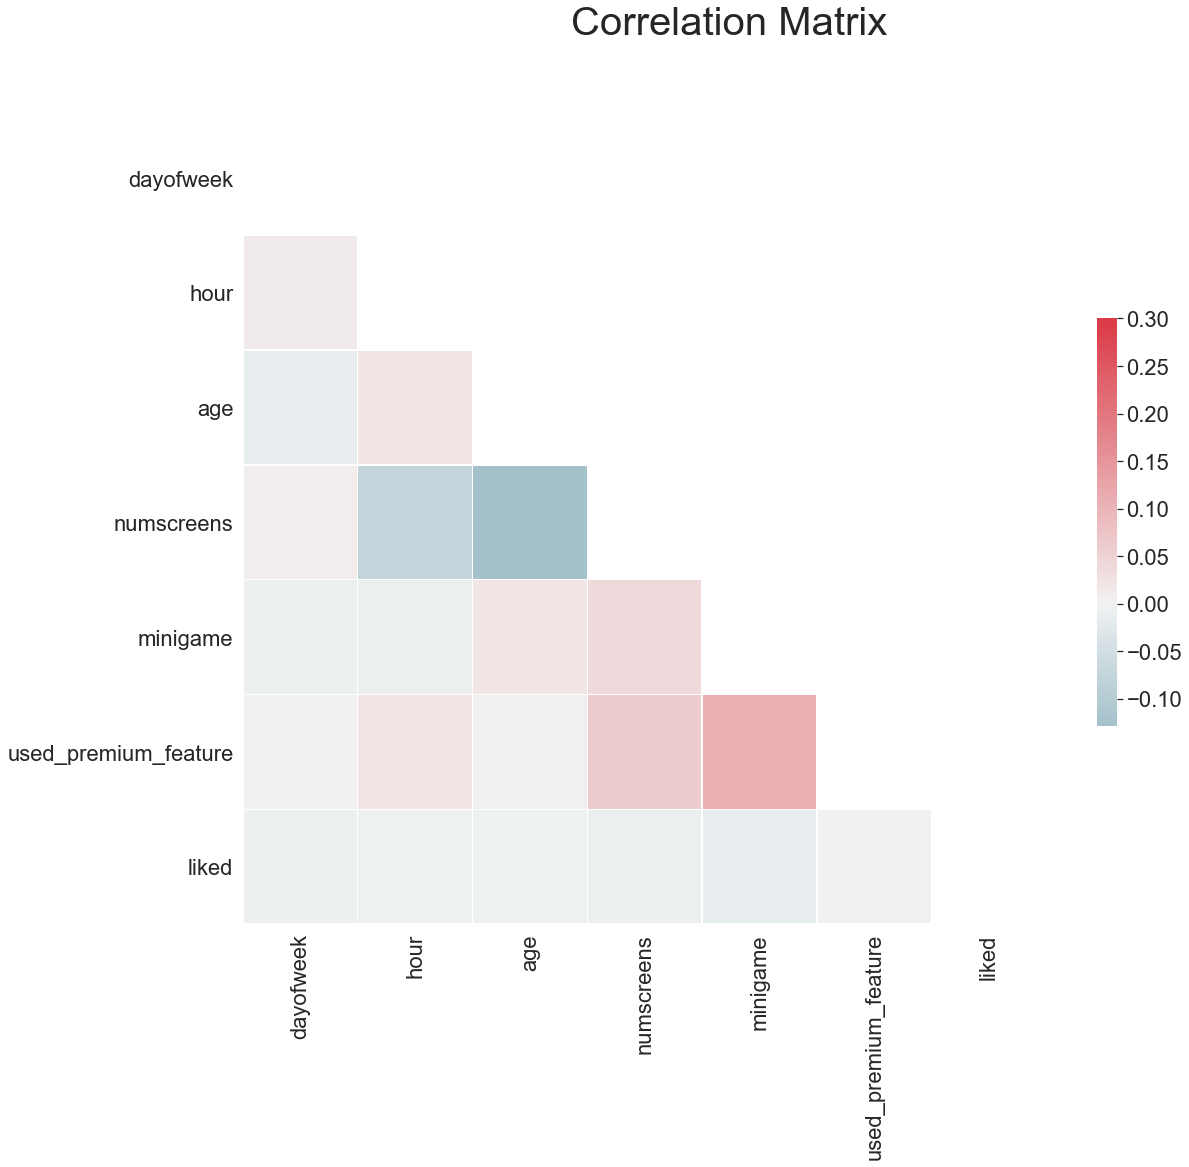

In [14]:

sns.set(style="white", font_scale=2)

corr = df_copy.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 15))
f.suptitle("Correlation Matrix", fontsize = 40)


cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



# Feature engineering

In [15]:
df_copy=df.copy()

In [16]:
df_copy.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int32
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

In [17]:
df_copy.head(10)

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1
5,56480,2013-04-03 09:58:15.752,2,9,20,"idscreen,Cycle,Home,ScanPreview,VerifyPhone,Ve...",14,0,0,1,2013-04-03 09:59:03.291,0
6,144649,2012-12-25 02:33:18.461,1,2,35,"product_review,product_review2,ScanPreview",3,0,0,0,NaN,0
7,249366,2012-12-11 03:07:49.875,1,3,26,"Splash,Cycle,Home,Credit3Container,Credit3Dash...",41,0,1,0,NaN,0
8,372004,2013-03-20 14:22:01.569,2,14,29,"product_review,product_review2,ScanPreview,Ver...",33,1,1,1,2013-04-27 22:24:54.542,0
9,338013,2013-04-26 18:22:16.013,4,18,26,"Home,Loan2,product_review,product_review,produ...",19,0,0,1,2013-04-26 18:31:58.923,0


## For date

In [18]:
df_copy["first_open"] = [parser.parse(row_date) for row_date in df_copy["first_open"]]

In [19]:
df_copy["enrolled_date"] = [parser.parse(row_date) if isinstance(row_date, str) else row_date for row_date in df_copy["enrolled_date"]]

In [20]:
df_copy.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int32
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

In [21]:
df_copy["time_to_sub"]=(df_copy.enrolled_date-df_copy.first_open).astype('timedelta64[h]')

In [22]:
df_copy.head(10)

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked,time_to_sub
0,235136,2012-12-27 02:14:51.273,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaT,0,NaN
1,333588,2012-12-02 01:16:00.905,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaT,0,NaN
2,254414,2013-03-19 19:19:09.157,1,19,23,"Splash,Cycle,Loan",3,0,1,0,NaT,1,NaN
3,234192,2013-07-05 16:08:46.354,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0,0.0
4,51549,2013-02-26 18:50:48.661,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1,0.0
5,56480,2013-04-03 09:58:15.752,2,9,20,"idscreen,Cycle,Home,ScanPreview,VerifyPhone,Ve...",14,0,0,1,2013-04-03 09:59:03.291,0,0.0
6,144649,2012-12-25 02:33:18.461,1,2,35,"product_review,product_review2,ScanPreview",3,0,0,0,NaT,0,NaN
7,249366,2012-12-11 03:07:49.875,1,3,26,"Splash,Cycle,Home,Credit3Container,Credit3Dash...",41,0,1,0,NaT,0,NaN
8,372004,2013-03-20 14:22:01.569,2,14,29,"product_review,product_review2,ScanPreview,Ver...",33,1,1,1,2013-04-27 22:24:54.542,0,920.0
9,338013,2013-04-26 18:22:16.013,4,18,26,"Home,Loan2,product_review,product_review,produ...",19,0,0,1,2013-04-26 18:31:58.923,0,0.0


<AxesSubplot:>

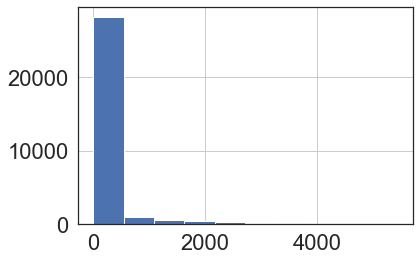

In [23]:
df_copy["time_to_sub"].dropna().hist()

<AxesSubplot:>

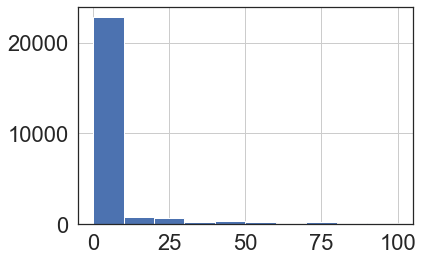

In [24]:
df_copy["time_to_sub"].dropna().hist(range=[0,100])

In [25]:
df_copy.loc[df_copy.time_to_sub > 48, 'enrolled'] = 0 # Two days This is done to remove outliers since majority of subscription occurs within 1 day of usage
df_copy = df_copy.drop(columns=['enrolled_date', 'time_to_sub', 'first_open'])


In [26]:
df_copy.head(10)

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,liked
0,235136,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,0
1,333588,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0
2,254414,1,19,23,"Splash,Cycle,Loan",3,0,1,0,1
3,234192,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,0
4,51549,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,1
5,56480,2,9,20,"idscreen,Cycle,Home,ScanPreview,VerifyPhone,Ve...",14,0,0,1,0
6,144649,1,2,35,"product_review,product_review2,ScanPreview",3,0,0,0,0
7,249366,1,3,26,"Splash,Cycle,Home,Credit3Container,Credit3Dash...",41,0,1,0,0
8,372004,2,14,29,"product_review,product_review2,ScanPreview,Ver...",33,1,1,0,0
9,338013,4,18,26,"Home,Loan2,product_review,product_review,produ...",19,0,0,1,0


## For screen

In [27]:
# Makes a list of all the items in the screen_list
list1=[i.split(',') for i in df_copy["screen_list"]]
list1=[j for i in list1 for j in i]

In [28]:
df_screens=pd.DataFrame(list1)

<AxesSubplot:>

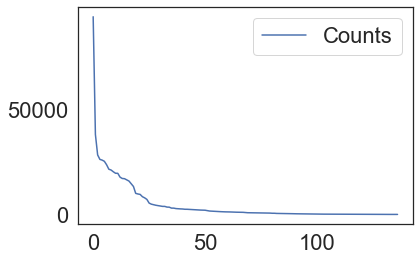

In [29]:
pd.DataFrame(df_screens.value_counts().rename_axis("Screens").reset_index(name="Counts")).plot()

In [30]:
top_screens=pd.DataFrame(df_screens.value_counts()[:60].rename_axis("Screens").reset_index(name="Counts"))

In [31]:
top_screens

,Screens,Counts
0,product_review,94218
1,Home,38098
2,ScanPreview,28351
3,VerifyPhone,26230
4,location,25888
5,Loan2,25319
6,VerifyDateOfBirth,23674
7,VerifySSN,21546
8,VerifyCountry,21158
9,VerifyToken,20332


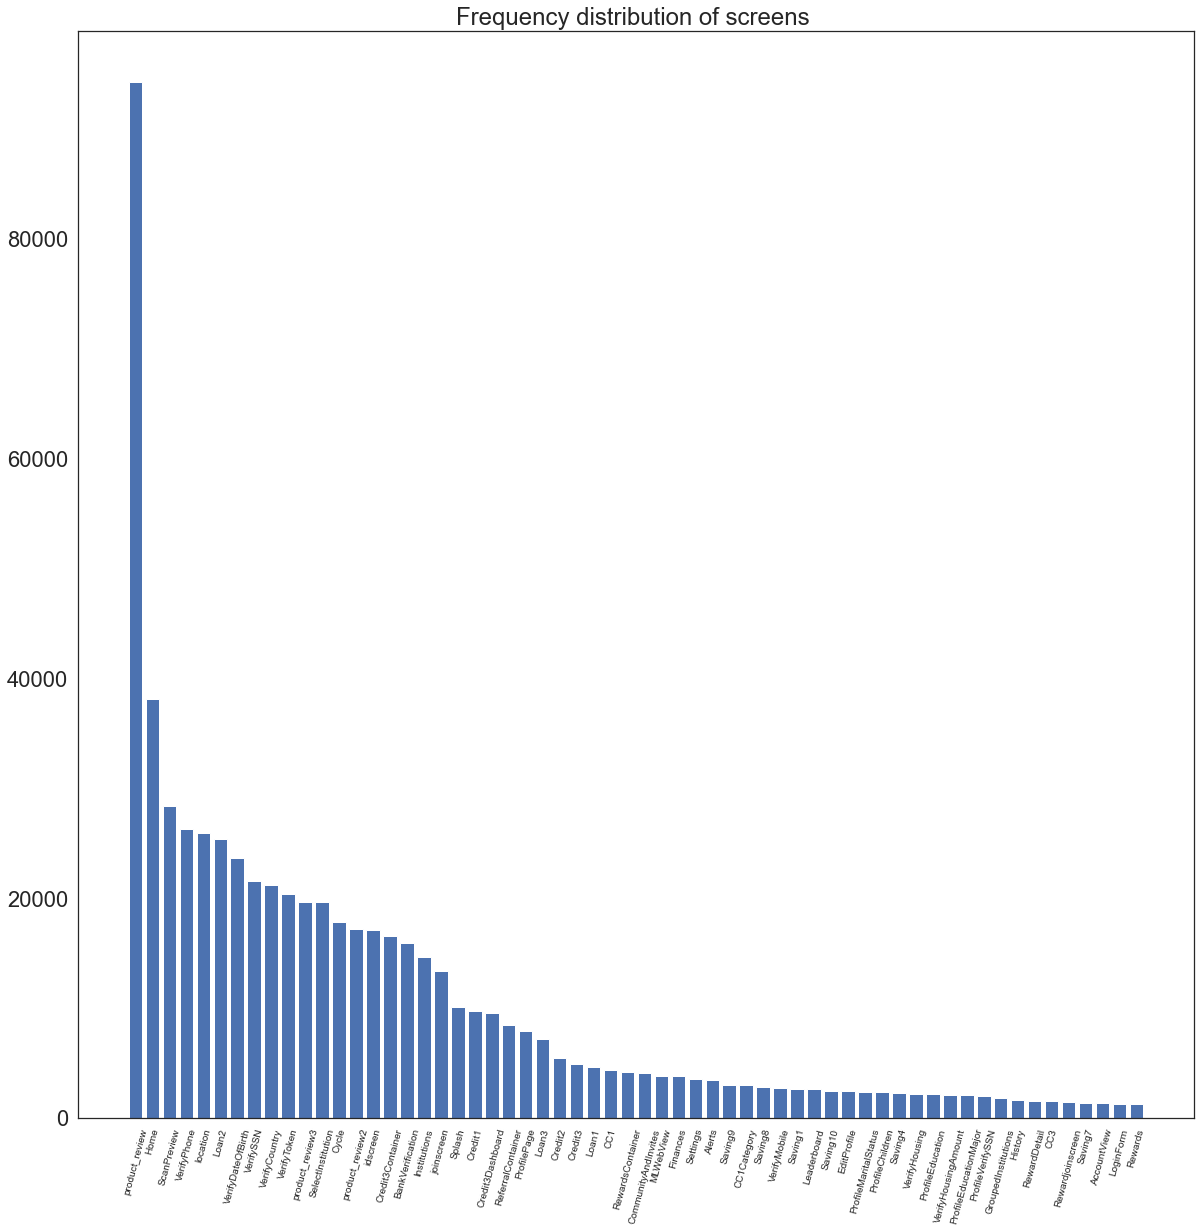

In [32]:
plt.figure(figsize=(20,20))
plt.bar(range(len(top_screens)),top_screens["Counts"])
plt.xticks(range(len(top_screens)),top_screens["Screens"],rotation=75,fontsize=10)
plt.title("Frequency distribution of screens ")
plt.show()

In [33]:
df_copy.screen_list.astype(str)+','

0        idscreen,joinscreen,Cycle,product_review,ScanP...
1        joinscreen,product_review,product_review2,Scan...
2                                       Splash,Cycle,Loan,
3        product_review,Home,product_review,Loan3,Finan...
4        idscreen,joinscreen,Cycle,Credit3Container,Sca...
                               ...                        
49995    Splash,Home,ScanPreview,VerifyPhone,VerifySSN,...
49996                  Cycle,Splash,Home,RewardsContainer,
49997    joinscreen,product_review,product_review2,Scan...
49998    Cycle,Home,product_review,product_review,produ...
49999    product_review,ScanPreview,VerifyDateOfBirth,V...
Name: screen_list, Length: 50000, dtype: object

In [34]:
df_copy["screen_list"]=df_copy.screen_list.astype(str)+','

In [35]:
df_copy.head(10)

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,liked
0,235136,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,0
1,333588,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0
2,254414,1,19,23,"Splash,Cycle,Loan,",3,0,1,0,1
3,234192,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,0
4,51549,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,1
5,56480,2,9,20,"idscreen,Cycle,Home,ScanPreview,VerifyPhone,Ve...",14,0,0,1,0
6,144649,1,2,35,"product_review,product_review2,ScanPreview,",3,0,0,0,0
7,249366,1,3,26,"Splash,Cycle,Home,Credit3Container,Credit3Dash...",41,0,1,0,0
8,372004,2,14,29,"product_review,product_review2,ScanPreview,Ver...",33,1,1,0,0
9,338013,4,18,26,"Home,Loan2,product_review,product_review,produ...",19,0,0,1,0


In [36]:
df_copy.numscreens=df_copy.screen_list.str.count(',')

In [37]:
for screen in top_screens.Screens:
    df_copy[screen]=df_copy.screen_list.str.contains(screen).astype(int)
    df_copy['screen_list'] = df_copy.screen_list.str.replace(screen+",", "")

In [38]:
df_copy['Other'] = df_copy.screen_list.str.count(",")
df_copy = df_copy.drop(columns=['screen_list'])

In [39]:
savings_screens = ["Saving1",
                    "Saving4",
                    "Saving7",
                    "Saving8",
                    "Saving9",
                    "Saving10"]
df_copy["SavingCount"] = df_copy[savings_screens].sum(axis=1)
df_copy = df_copy.drop(columns=savings_screens)

In [40]:
cm_screens = ["Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]
df_copy["CMCount"] = df_copy[cm_screens].sum(axis=1)
df_copy = df_copy.drop(columns=cm_screens)

In [41]:
cc_screens = ["CC1",
                "CC1Category",
                "CC3"]
df_copy["CCCount"] = df_copy[cc_screens].sum(axis=1)
df_copy = df_copy.drop(columns=cc_screens)

In [42]:

loan_screens = [
               "Loan2",
               "Loan3"]
df_copy["LoansCount"] = df_copy[loan_screens].sum(axis=1)
df_copy = df_copy.drop(columns=loan_screens)

In [43]:
df_copy.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,product_review,...,RewardDetail,Rewardjoinscreen,AccountView,LoginForm,Rewards,Other,SavingCount,CMCount,CCCount,LoansCount
0,235136,3,2,23,13,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,1
1,333588,6,1,24,11,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,234192,4,16,28,17,0,0,1,0,1,...,1,0,0,0,1,0,0,3,0,1
4,51549,1,18,31,19,0,0,1,1,1,...,0,0,0,0,0,0,0,2,0,1


In [45]:
df_copy.to_csv(r"C:\Users\noname797\Documents\ML_projects\Case_study\Datasets\processed_data_subs.csv",index=False)

# Model Training

In [50]:
df=pd.read_csv(r"C:\Users\noname797\Documents\ML_projects\Case_study\Datasets\processed_data_subs.csv")
df.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,product_review,...,RewardDetail,Rewardjoinscreen,AccountView,LoginForm,Rewards,Other,SavingCount,CMCount,CCCount,LoansCount
0,235136,3,2,23,13,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,1
1,333588,6,1,24,11,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,234192,4,16,28,17,0,0,1,0,1,...,1,0,0,0,1,0,0,3,0,1
4,51549,1,18,31,19,0,0,1,1,1,...,0,0,0,0,0,0,0,2,0,1


In [51]:
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values :  \n",df.nunique())

Rows     :  50000
Columns  :  58

Features : 
 ['user', 'dayofweek', 'hour', 'age', 'numscreens', 'minigame', 'used_premium_feature', 'enrolled', 'liked', 'product_review', 'Home', 'ScanPreview', 'VerifyPhone', 'location', 'VerifyDateOfBirth', 'VerifySSN', 'VerifyCountry', 'VerifyToken', 'product_review3', 'SelectInstitution', 'Cycle', 'product_review2', 'idscreen', 'BankVerification', 'Institutions', 'joinscreen', 'Splash', 'ReferralContainer', 'ProfilePage', 'Loan1', 'RewardsContainer', 'CommunityAndInvites', 'MLWebView', 'Finances', 'Settings', 'Alerts', 'VerifyMobile', 'Leaderboard', 'EditProfile', 'ProfileMaritalStatus', 'ProfileChildren', 'VerifyHousing', 'ProfileEducation', 'VerifyHousingAmount', 'ProfileEducationMajor', 'ProfileVerifySSN', 'GroupedInstitutions', 'History', 'RewardDetail', 'Rewardjoinscreen', 'AccountView', 'LoginForm', 'Rewards', 'Other', 'SavingCount', 'CMCount', 'CCCount', 'LoansCount']

Missing values :   0

Unique values :  
 user                     49874


In [52]:
target=df["enrolled"]
features=df.drop(columns="enrolled")

<AxesSubplot:title={'center':'Correlation with Enrollment rate'}>

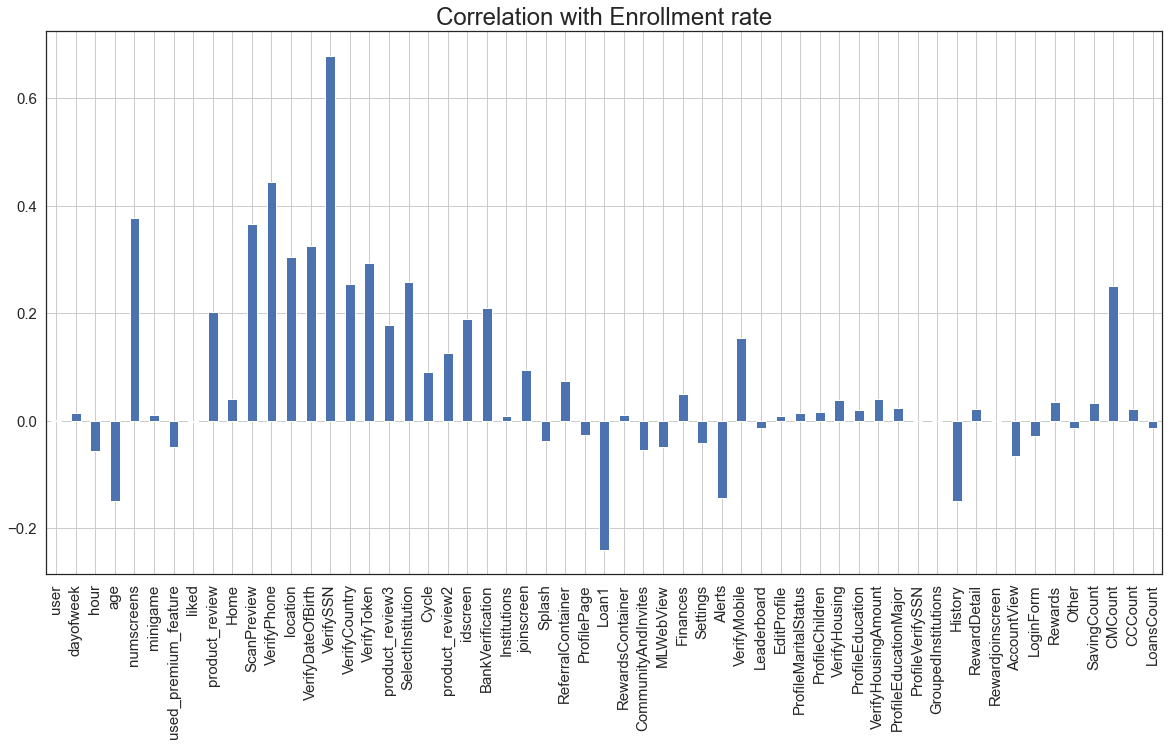

In [53]:

features.corrwith(target).plot.bar(figsize=(20,10),
                  title = 'Correlation with Enrollment rate',
                  fontsize = 15, rot = 90,
                  grid = True)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size = 0.2,
                                                    stratify=target)


In [55]:
train_id = X_train['user']
X_train = X_train.drop(columns = ['user'])
test_id = X_test['user']
X_test = X_test.drop(columns = ['user'])

In [56]:
scaler=StandardScaler()

X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_train_scaled

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked,product_review,Home,ScanPreview,...,RewardDetail,Rewardjoinscreen,AccountView,LoginForm,Rewards,Other,SavingCount,CMCount,CCCount,LoansCount
0,-0.015658,1.001184,-0.437397,-0.280523,2.881000,-0.454893,-0.445213,0.631000,0.558832,0.873214,...,-0.177518,0.0,-0.164829,-0.16021,-0.156729,-0.391664,-0.256771,0.059277,-0.289319,0.732107
1,-1.492811,-1.690677,-0.992269,-0.562873,-0.347102,-0.454893,-0.445213,0.631000,-1.789447,0.873214,...,-0.177518,0.0,-0.164829,-0.16021,-0.156729,-0.391664,-0.256771,0.059277,-0.289319,0.732107
2,0.969111,-1.286898,0.117476,0.566530,-0.347102,-0.454893,-0.445213,0.631000,0.558832,0.873214,...,-0.177518,0.0,-0.164829,-0.16021,-0.156729,0.430080,-0.256771,-0.763439,-0.289319,0.732107
3,1.461496,-1.556084,-0.992269,0.425354,-0.347102,-0.454893,-0.445213,0.631000,-1.789447,0.873214,...,-0.177518,0.0,-0.164829,-0.16021,-0.156729,-0.391664,-0.256771,-0.763439,-0.289319,-1.365620
4,-1.000427,-1.152305,-0.529875,-0.704049,-0.347102,-0.454893,-0.445213,-1.584785,0.558832,-1.145195,...,-0.177518,0.0,-0.164829,-0.16021,-0.156729,2.073569,-0.256771,0.059277,-0.289319,-1.365620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1.461496,1.404963,0.394912,3.107687,-0.347102,-0.454893,-0.445213,0.631000,0.558832,0.873214,...,-0.177518,0.0,-0.164829,-0.16021,-0.156729,2.895313,5.091239,2.527423,-0.289319,0.732107
39996,-1.492811,0.866591,0.949784,0.566530,2.881000,-0.454893,-0.445213,0.631000,-1.789447,0.873214,...,-0.177518,0.0,-0.164829,-0.16021,-0.156729,0.430080,-0.256771,0.881992,-0.289319,-1.365620
39997,-1.492811,-1.690677,-0.344918,-1.268750,-0.347102,-0.454893,-0.445213,-1.584785,0.558832,-1.145195,...,-0.177518,0.0,-0.164829,-0.16021,-0.156729,0.430080,-0.256771,-0.763439,-0.289319,0.732107
39998,0.476727,0.731998,0.949784,-0.280523,-0.347102,-0.454893,2.246116,-1.584785,0.558832,-1.145195,...,-0.177518,0.0,-0.164829,-0.16021,-0.156729,-0.391664,-0.256771,1.704708,-0.289319,-1.365620


Text(0, 0.5, 'cumulative explained variance')

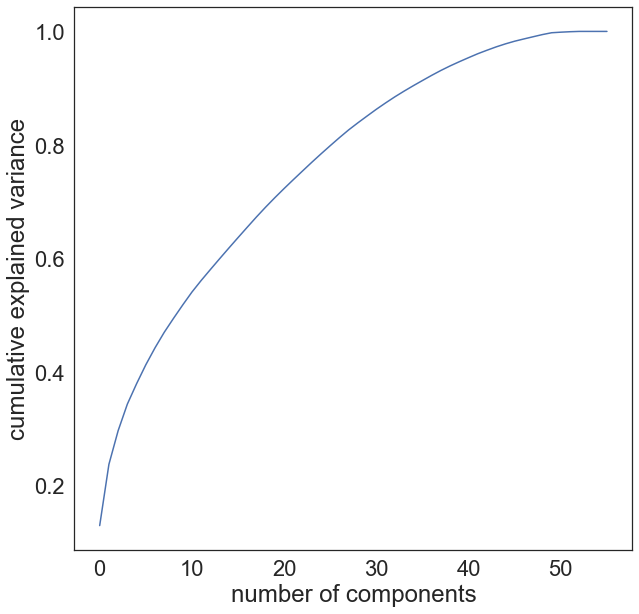

In [57]:
pca = PCA().fit(X_train_scaled,y_train)
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [58]:
pca_X = PCA(n_components=41).fit(X_train_scaled,y_train) # accumulates 95+ percent of variance
principalComponents_X = pca_X.transform(X_train_scaled)

In [59]:
principalComponents_X.shape,y_train.shape

((40000, 41), (40000,))

In [60]:
X_test_scaled=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)


In [61]:
principalComponents_X_test = pca_X.transform(X_test_scaled)

In [62]:
principalComponents_X_test.shape

(10000, 41)

In [63]:
model = LogisticRegression()
model.fit(principalComponents_X, y_train)

predictions = model.predict(principalComponents_X_test)
score = model.score(principalComponents_X_test, y_test)

print("Accuracy = " + str(score))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy = 0.8133
[[4206  824]
 [1043 3927]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      5030
           1       0.83      0.79      0.81      4970

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



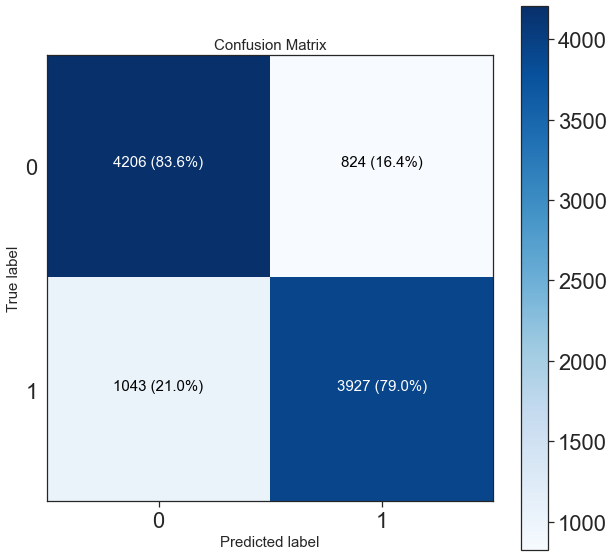

In [64]:
make_confusion_matrix(y_test,predictions)

In [66]:
roc_auc_score(y_test,predictions)

0.8131618738274577

In [65]:
model.get_params

<bound method BaseEstimator.get_params of LogisticRegression()>

In [67]:

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 4, 8]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [26]:
# Takes too long
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(principalComponents_X, y_train)

In [27]:
# rf_random.best_params_

In [75]:
base_model = RandomForestClassifier()
base_model.fit(principalComponents_X, y_train)


RandomForestClassifier()

In [76]:
predictions = base_model.predict(principalComponents_X_test)
score = base_model.score(principalComponents_X_test, y_test)

print("Accuracy = " + str(score))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy = 0.8095
[[4200  830]
 [1075 3895]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      5030
           1       0.82      0.78      0.80      4970

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



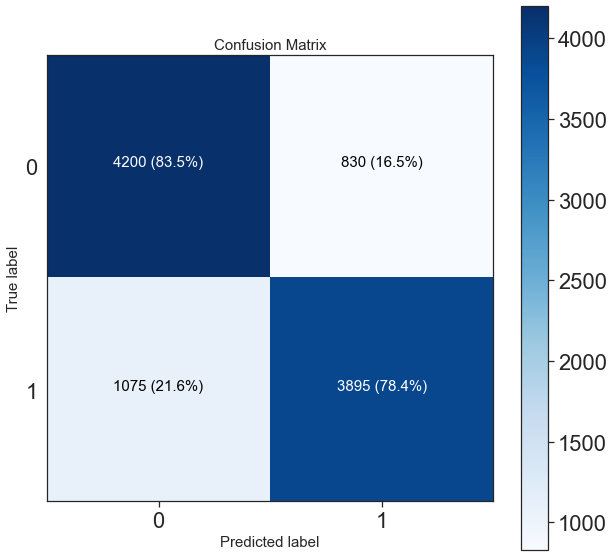

In [77]:
make_confusion_matrix(y_test,predictions)

In [78]:
roc_auc_score(y_test,predictions)

0.8093461364609126

In [79]:
# best_random = rf_random.best_estimator_
# best_random.fit(principalComponents_X, y_train)

In [80]:
# predictions = best_random.predict(principalComponents_X_test)
# score = best_random.score(principalComponents_X_test, y_test)

# print("Accuracy = " + str(score))
# print(confusion_matrix(y_test, predictions))
# print(classification_report(y_test, predictions))

In [81]:
model = Sequential([
    Dense(256, kernel_initializer = "uniform",activation = "relu"),
    Dense(128, kernel_initializer = "uniform",activation = "relu"),
    Dense(64, kernel_initializer = "uniform",activation = "relu"),
    Dense(1, kernel_initializer = "uniform",activation = "sigmoid")
])
model.compile(optimizer= "adam",loss = "binary_crossentropy",metrics = ["accuracy"])


In [83]:
checkpoint=ModelCheckpoint(r"C:\Users\noname797\Documents\ML_projects\Case_study\Datasets\trained_model]subs.hd5",monitor="val_loss",mode="min",
                           save_best_only=True,verbose=1)

earlystop=EarlyStopping(monitor="val_loss",min_delta=0,patience=4,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2,verbose=1,min_delta=0.0001)

callbacks=[checkpoint,earlystop,reduce_lr]

In [84]:
batch_size = 32
epochs = 25

history = model.fit(principalComponents_X, y_train,
                    batch_size = batch_size, 
                    epochs = epochs,
                    callbacks=callbacks,
                    verbose = 1,
                    validation_data = (principalComponents_X_test, y_test))


Epoch 1/25
1241/1250 [============================>.] - ETA: 0s - loss: 0.4206 - accuracy: 0.8190
Epoch 00001: val_loss improved from inf to 0.40155, saving model to C:\Users\noname797\Documents\ML_projects\Case_study\Datasets\trained_model]subs.hd5
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\noname797\Documents\ML_projects\Case_study\Datasets\trained_model]subs.hd5\assets
1250/1250 [==============================] - 3s 3ms/step - loss: 0.4204 - accuracy: 0.8190 - val_loss: 0.4016 - val_accuracy: 0.8256
Epoch 2/25
1227/1250 [============================>.] - ETA: 0s - loss: 0.3963 - accuracy: 0.8294
Epoch 00002: val_loss improved from 0.40155 to 0.39739, saving model to C:\Users\noname797\Documents\ML_projects\Case_study\Datasets\trained_model]subs.hd5
INF

In [85]:
predictions = base_model.predict(principalComponents_X_test)
score = model.evaluate(principalComponents_X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.38494229316711426
Test accuracy: 0.8360000252723694


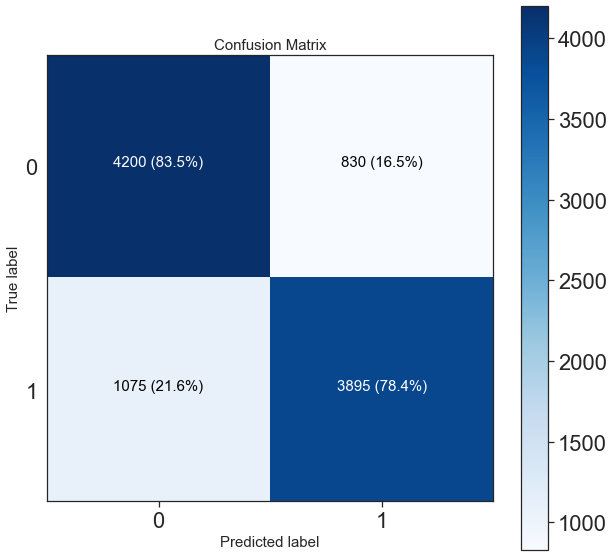

In [86]:
make_confusion_matrix(y_test,predictions)

In [87]:
roc_auc_score(y_test,predictions)

0.8093461364609126

In [41]:
!zip -r /content/subs.zip /content/trained_model

  adding: content/trained_model/ (stored 0%)
  adding: content/trained_model/subs.hd5/ (stored 0%)
  adding: content/trained_model/subs.hd5/keras_metadata.pb (deflated 89%)
  adding: content/trained_model/subs.hd5/variables/ (stored 0%)
  adding: content/trained_model/subs.hd5/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/trained_model/subs.hd5/variables/variables.index (deflated 65%)
  adding: content/trained_model/subs.hd5/assets/ (stored 0%)
  adding: content/trained_model/subs.hd5/saved_model.pb (deflated 88%)
